## Industrial Machine Fault Detection using Deep Learning
### Machines: Pumps, motors, valves etc. 

### Training a MLP on MFCC features generated from equipment sound files

- Rajesh Siraskar | 23-May-2021
----
- V.3.0: CNN for audio category classification
---- 

- Load data
- Create train/validation/test sets (unseen)
- Build CNN network architecture
- Compile network
- Train network
- Evaluate
- Make predictions on a sample

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

from utilities import *
%matplotlib inline

C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rajes\anaconda3\envs\dsp\lib\site-packages\tensorflow\python\framework

In [2]:
JSON_FILE = "audio_files/machine_features.json"
NUMBER_OF_CLASSES = 6 # Machine normal/abnormal
TRAIN_EPOCHS = 200

### 1. Create train/validation/test sets (unseen)
--------------------------------------------------------

#### Note: CNN expects a 3-D array.
    - Our data was saved with the following parameters
    - num_mfcc=13; num_segments=10; num_mfcc_vectors_per_segment: 130
    - X.data.shape:  (80, 130, 13)
    - y.data.shape:  (80,)
    
    - X.data.shape: dim-1: No of samples = 4 classes * 2 .wav files per genre * 10 segments = 80, 
    -               dim-2: time-bins = 130, 
    -               dim-3: mfcc-features = 13)

### For CNN we need to add an additional channel: 
    - Loaded X is (80, 130, 1)
    - For CNN, X needs to be (130, 13, 1)
    - The 3rd dim is the CHANNEL so will be 1
    - So X becomes actually a 4D arraay with the added channel dim

In [6]:
def prepare_datasets(test_size=0.25, validation_size=0.2):
    # load data
    X, y = load_data(JSON_FILE)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # create train/validation set
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                    test_size=validation_size)
    
    # CNN expects a 3-D array
    # -----------------------
    # Our data was saved with the following parameters
    #    num_mfcc=13; num_segments=10; num_mfcc_vectors_per_segment: 130
    # X.data.shape: dim-1: No of samples = 4 classes * 2 .wav files per genre * 10 segments = 80, 
    #               dim-2: time-bins = 130, 
    #               dim-3: mfcc-features = 13)
    # y.data.shape:  (80,)
    #
    #
    # For CNN we need to add an additional channel: 
    # - Loaded X is (80, 130, 1)
    # - For CNN, X needs to be (130, 13, 1)
    # - The 3rd dim is the CHANNEL so will be 1
    # - So X becomes actually a 4D arraay with the added channel dim
    
    # Create the 3-D array for X_train, but first add newaxis for channel
    X_train = X_train [..., np.newaxis]           # 4D array = [num_sample, 130, 13, 1]
    X_validation = X_validation [..., np.newaxis] # -- "" --
    X_test = X_test [..., np.newaxis]             # -- "" --
    
    # Return the 4-D data
    return  X_train, X_validation, X_test, y_train, y_validation, y_test

### 2. Build the CNN network

In [7]:
def build_model(input_shape):
    
    # Ceate model
    model = keras.Sequential()
    # 1st conv. layer (along with max-pooling,normalize output - which speeds up training)
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                                  input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())              
    
    # 2nd. conv. layer - same as above. Note input shape remains same
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                                  input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())                      
    
    # 3rd. conv. layer - same as above but reduce filter sizes (both kernel and pooling)
    # Again, note, input shape remains same
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 
    
    # Flatten the output and feed to a dense layer, also add dropout to reduce over-fitting
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # Final output layer with softmax) for classification
    # Neurons = number of classes i.e. genres = NUMBER_OF_CLASSES
    model.add(keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
    
    return model

### Utility functions: 
1. Plot accuracy/loss curves
2. Load JSON data file and return genre names

### Main function
1. Create train/validation/test sets (unseen)
2. Build the CNN network
3. Compile the network
4. Train the model
5. Evaluate the model on unseen test set
6. Predict on a sample

In [8]:
## 1. Create train/validation/test sets (unseen)
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(test_size=0.25, 
                                                                                validation_size=0.2)
## 2. Build the CNN network
#  X_train is a 4-D array. For input shape, take the 3-dims from dimension 2 onwards. 
#  The 1st dim was num_samples and is not considered as it will be part of training samples
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

## 3. Compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 4. Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_validation, y_validation), 
                    batch_size=32, 
                    epochs=TRAIN_EPOCHS) # 30 epochs accuracy=0.70; 400 epochs=0.95

## 5. Evaluate the model on unseen test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1) 
print("\n\n - Accuracy on un-seen test set: {0:.3f}".format(test_accuracy))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 432 samples, validate on 108 samples
Epoch 1/200
432/432 [==============================] - 1s 1ms/sample - loss: 2.5005 - acc: 0.1481 - val_loss: 2.7605 - val_acc: 0.1296
Epoch 2/200
432/432 [==============================] - 0s 602us/sample - loss: 2.2510 - acc: 0.1690 - val_loss: 2.3754 - val_acc: 0.1296
Epoch 3/200
432/432 [==============================] - 0s 602us/sample - loss: 2.2616 - acc: 0.1782 - val_loss: 2.1846 - val_acc: 0.1481
Epoch 4/200
432/432 [==============================] - 0s 580us/sample - loss: 2.0686 - acc: 0.2060 - val_loss: 2.0754 - val_acc: 0.1296
Epoch 5/200
432/432 [==============================] - 0s 578us/sample - loss: 1.9886 - acc: 0.2014 - val_loss: 2.0032 - val_acc: 0.0926
Epoch 6/200
432/432 [==============================] - 0s 536us/sample - loss: 2.0132 - acc: 0.2222 - val_loss: 1.9456 - val_acc: 0.1019
Epoch 7/200
432/

432/432 [==============================] - 0s 534us/sample - loss: 1.3585 - acc: 0.4005 - val_loss: 2.0818 - val_acc: 0.1574
Epoch 58/200
432/432 [==============================] - 0s 555us/sample - loss: 1.3622 - acc: 0.3935 - val_loss: 2.0625 - val_acc: 0.1852
Epoch 59/200
432/432 [==============================] - 0s 556us/sample - loss: 1.3510 - acc: 0.4051 - val_loss: 2.0432 - val_acc: 0.1944
Epoch 60/200
432/432 [==============================] - 0s 525us/sample - loss: 1.3522 - acc: 0.3889 - val_loss: 2.0238 - val_acc: 0.1852
Epoch 61/200
432/432 [==============================] - 0s 535us/sample - loss: 1.3371 - acc: 0.4259 - val_loss: 2.0707 - val_acc: 0.1667
Epoch 62/200
432/432 [==============================] - 0s 555us/sample - loss: 1.3671 - acc: 0.3796 - val_loss: 2.0662 - val_acc: 0.1574
Epoch 63/200
432/432 [==============================] - 0s 573us/sample - loss: 1.3612 - acc: 0.4398 - val_loss: 2.0622 - val_acc: 0.1667
Epoch 64/200
432/432 [=========================

432/432 [==============================] - 0s 543us/sample - loss: 1.1735 - acc: 0.4560 - val_loss: 2.2645 - val_acc: 0.1204
Epoch 117/200
432/432 [==============================] - 0s 518us/sample - loss: 1.2018 - acc: 0.4190 - val_loss: 2.3193 - val_acc: 0.1389
Epoch 118/200
432/432 [==============================] - 0s 532us/sample - loss: 1.1859 - acc: 0.4606 - val_loss: 2.2709 - val_acc: 0.1481
Epoch 119/200
432/432 [==============================] - 0s 557us/sample - loss: 1.2512 - acc: 0.4190 - val_loss: 2.2346 - val_acc: 0.1204
Epoch 120/200
432/432 [==============================] - 0s 556us/sample - loss: 1.2231 - acc: 0.4537 - val_loss: 2.2341 - val_acc: 0.1296
Epoch 121/200
432/432 [==============================] - 0s 508us/sample - loss: 1.2049 - acc: 0.4653 - val_loss: 2.2215 - val_acc: 0.1296
Epoch 122/200
432/432 [==============================] - 0s 532us/sample - loss: 1.1995 - acc: 0.4398 - val_loss: 2.1936 - val_acc: 0.1296
Epoch 123/200
432/432 [==================

432/432 [==============================] - 0s 508us/sample - loss: 1.1382 - acc: 0.4745 - val_loss: 2.4353 - val_acc: 0.1204
Epoch 176/200
432/432 [==============================] - 0s 492us/sample - loss: 1.1632 - acc: 0.4398 - val_loss: 2.4326 - val_acc: 0.1111
Epoch 177/200
432/432 [==============================] - 0s 555us/sample - loss: 1.1220 - acc: 0.4583 - val_loss: 2.4015 - val_acc: 0.1111
Epoch 178/200
432/432 [==============================] - 0s 533us/sample - loss: 1.1329 - acc: 0.4838 - val_loss: 2.4341 - val_acc: 0.1111
Epoch 179/200
432/432 [==============================] - 0s 554us/sample - loss: 1.1290 - acc: 0.4560 - val_loss: 2.4206 - val_acc: 0.1019
Epoch 180/200
432/432 [==============================] - 0s 534us/sample - loss: 1.1717 - acc: 0.4259 - val_loss: 2.4323 - val_acc: 0.1111
Epoch 181/200
432/432 [==============================] - 0s 532us/sample - loss: 1.1434 - acc: 0.4792 - val_loss: 2.4472 - val_acc: 0.1296
Epoch 182/200
432/432 [==================

In [9]:
## 5. Evaluate the model on unseen test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=0) 
print("- Accuracy on un-seen test set: {0:.3f}".format(test_accuracy))

- Accuracy on un-seen test set: 0.128


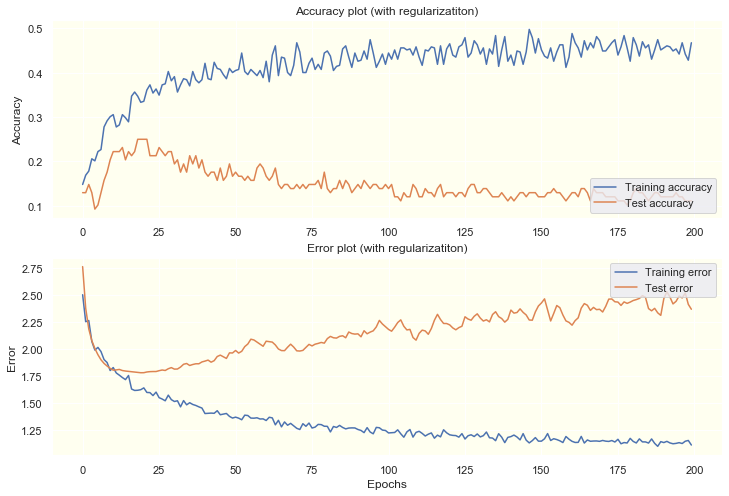

In [10]:
## 7. Plot training curves - NO regularization
plot_history(history, regularization_flag=True)

In [11]:
import random

# First get the labels from the numerical indices, so that predicted vales are readable
signal_label_mappings = map_signal_labels(JSON_FILE)

## 6. Predict
for n in range(20):
    sample = random.randint(0,19) # Total 20 samples, so select any sample 1-20
    X = X_test[sample] 
    y = y_test[sample]

    predict(model, X, y, signal_label_mappings)

Expected machine signal: 'motor_normal' 	|  Predicted: 'valve_normal'
Expected machine signal: 'pump_normal' 	|  Predicted: 'pump_abnormal'
Expected machine signal: 'pump_normal' 	|  Predicted: 'valve_abnormal'
Expected machine signal: 'motor_normal' 	|  Predicted: 'pump_normal'
Expected machine signal: 'motor_normal' 	|  Predicted: 'pump_abnormal'
Expected machine signal: 'pump_normal' 	|  Predicted: 'valve_abnormal'
Expected machine signal: 'motor_normal' 	|  Predicted: 'pump_abnormal'
Expected machine signal: 'valve_abnormal' 	|  Predicted: 'motor_abnormal'
Expected machine signal: 'valve_normal' 	|  Predicted: 'pump_normal'
Expected machine signal: 'valve_normal' 	|  Predicted: 'pump_normal'
Expected machine signal: 'motor_normal' 	|  Predicted: 'pump_abnormal'
Expected machine signal: 'pump_normal' 	|  Predicted: 'valve_abnormal'
Expected machine signal: 'motor_abnormal' 	|  Predicted: 'motor_abnormal'
Expected machine signal: 'pump_normal' 	|  Predicted: 'valve_abnormal'
Expected